In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import time
import math
import datetime


# Import widgets
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

from math import log, floor
from sklearn.neighbors import KDTree

import seaborn as sns
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

import itertools
from itertools import cycle
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
sell_prices_df = pd.read_csv('Dataset\sell_prices.csv')
train_sales_df = pd.read_csv('Dataset\sales_train_validation.csv')
calendar_df = pd.read_csv('Dataset\calendar.csv')

In [3]:
d_cols = [c for c in train_sales_df.columns if 'd_' in c]
train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)
train_sales_df['avg_sales_all_days'] = train_sales_df[d_cols].mean(axis = 1)
train_sales_df['median_sales_all_days'] = train_sales_df[d_cols].median(axis = 1)
# train_sales_df.rename(columns={'item_id':'id'},inplace=True)
# train_sales_df['id'] = train_sales_df['item_id'] + '_' + train_sales_df['store_id']
# sell_prices_df['id'] = sell_prices_df['item_id'] + '_' + sell_prices_df['store_id']


In [4]:
train_sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,total_sales_all_days,avg_sales_all_days,median_sales_all_days
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,3,0,1,1,600,0.313643,0.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,1,0,0,0,0,493,0.257710,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,0,1,1,1,288,0.150549,0.0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,4,1,0,1,3,7,2,3288,1.718766,1.0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,1,2,2,2,4,1849,0.966545,1.0


In [50]:
df = train_sales_df.groupby(['dept_id', 'store_id', 'state_id', 'cat_id'])[train_sales_df.columns[5:]].sum().reset_index()
df = df.sort_values('total_sales_all_days', ascending=False)

In [51]:
df = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
fig = px.pie(df, values='total_entries', names='cat_id', 
            color_discrete_sequence=px.colors.sequential.RdBu,
            width = 750, height=450, title = 'Distribution of Product_IDs Across Categories')
fig.show()

In [52]:
df = train_sales_df.groupby(['state_id'])['total_sales_all_days'].sum().reset_index()
fig = px.pie(df, values='total_sales_all_days', names='state_id', 
            color_discrete_sequence=px.colors.sequential.Aggrnyl,
            width = 750, height=450, title = 'Distribution of Total_Sales Across States')
fig.show()

In [53]:
df1 = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
df2 = train_sales_df.groupby(['cat_id', 'state_id'])['total_sales_all_days'].sum().reset_index()

C:\Users\91976\AppData\Local\Temp\ipykernel_19200\3430106589.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




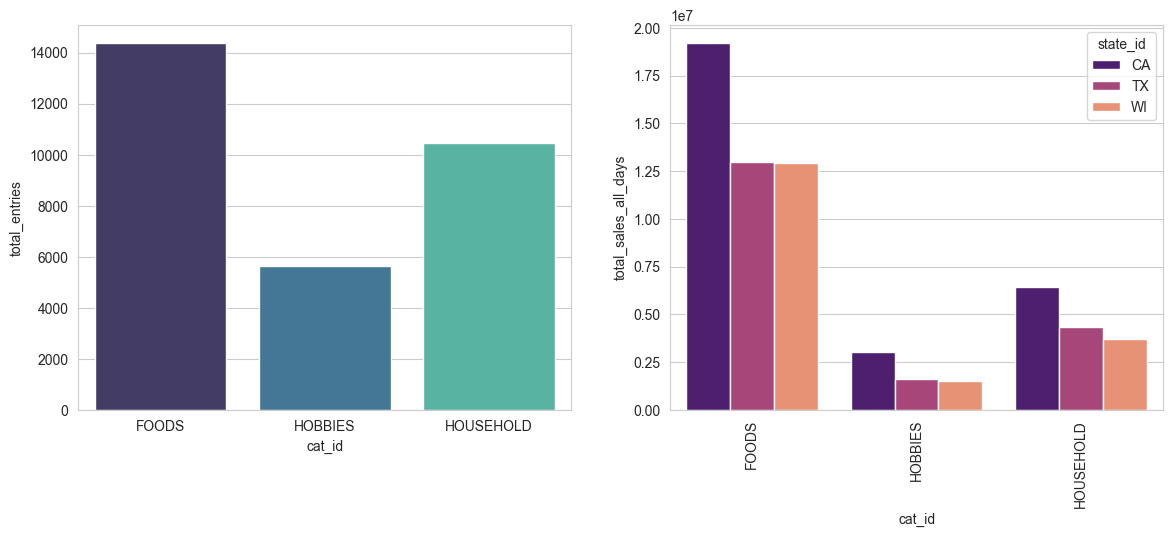

In [54]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.barplot(x = 'cat_id', y='total_entries', data=df1, 
            palette='mako', ax=ax1)
sns.barplot(x = 'cat_id', y='total_sales_all_days', hue='state_id', data=df2, 
            palette='magma', ax=ax2)

plt.xticks(rotation=90)
plt.show()

In [55]:
df = train_sales_df.groupby(['state_id', 'cat_id'])['id'].count().reset_index(name='num_sales_by_category')
fig = px.bar(df, x="state_id", y="num_sales_by_category", 
             color="cat_id", title="Distribution of Product_ids Count Across Categories & Each Locale")
fig.show()

In [5]:
train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

id
FOODS_3_090_CA_3_validation        250502
FOODS_3_586_TX_2_validation        192835
FOODS_3_586_TX_3_validation        150122
FOODS_3_586_CA_3_validation        134386
FOODS_3_090_CA_1_validation        127203
                                    ...  
FOODS_2_071_TX_3_validation            16
FOODS_2_057_WI_2_validation            16
HOBBIES_1_170_WI_3_validation          13
FOODS_3_778_CA_2_validation            12
HOUSEHOLD_1_020_CA_3_validation        10
Name: total_sales_all_days, Length: 30490, dtype: int64

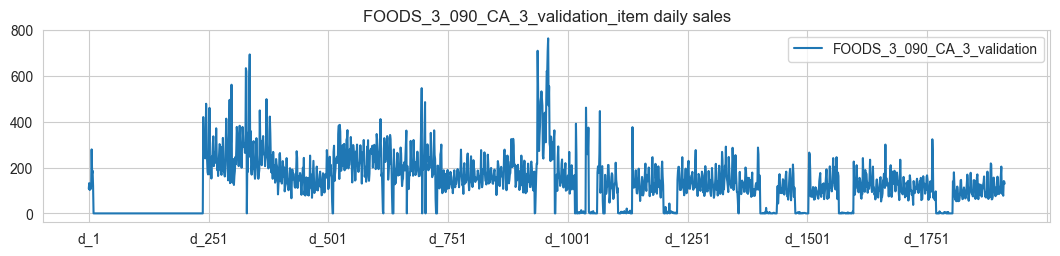

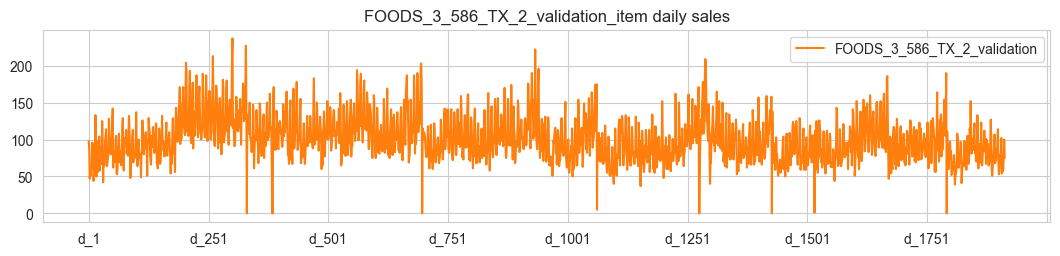

In [6]:
sns.set_style('whitegrid')

def plot_dailysales(spec_id):
    """
    plots the behavior of dailysales of specific ids i.e. spec_id
    
    input: spec_id
    returns : number of sales plotted across number of days 
    """
    train_sales_df.loc[train_sales_df['id'] == spec_id ].set_index('id')[d_cols]\
                .T\
                .plot(figsize = (13,2.5),
                      title =  str(spec_id)+"_item daily sales", 
                      color = next(color_cycle) )
    plt.legend()
    plt.show()

plot_dailysales('FOODS_3_090_CA_3_validation') 
plot_dailysales('FOODS_3_586_TX_2_validation')

In [58]:
# making a new column category out of the item_id 
sell_prices_df['category'] = sell_prices_df['item_id'].str.split("_", expand=True)[0]

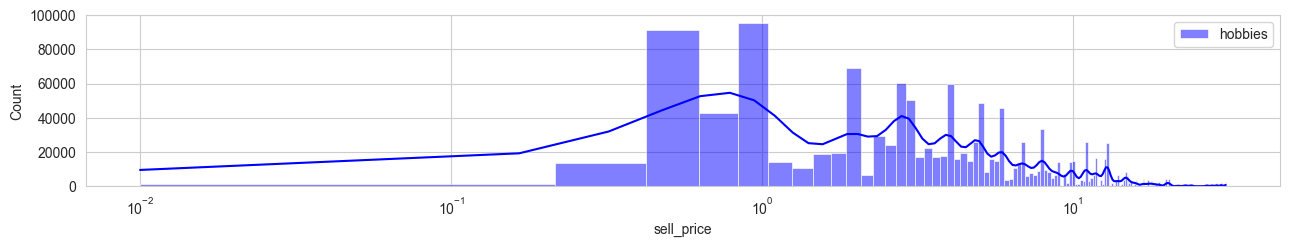

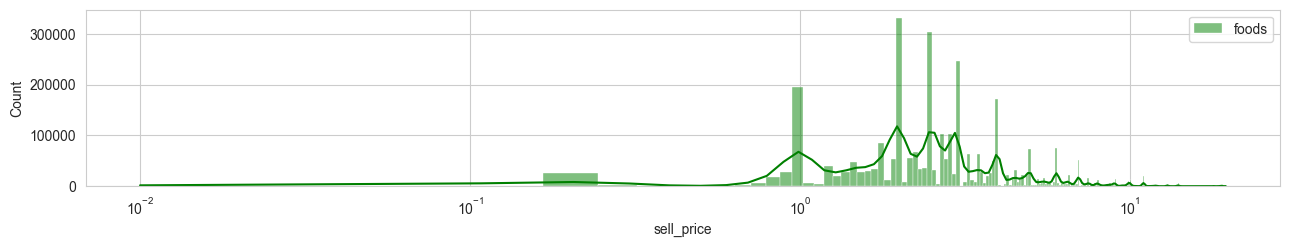

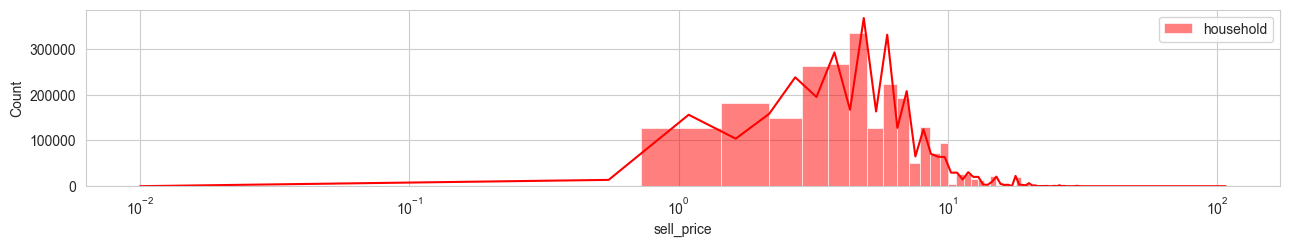

In [59]:
sns.set_style('whitegrid')
#plt.figure(figsize=(15,5))

def kde_plotting(df, category, bin_size, color, label):
    
    '''
    plots the kde density plot of the continuous features of df specified
    
    inputs: df, category(whether, foods, household or hobbies), bin_size(bin size for histogram)
            color (color of the plot), label (label to the plot)
    returns: kde plots with logarithmic scale taken on x_axis
            
    '''
    fig, ax1 = plt.subplots(figsize=(13, 2.5) )

    sns.histplot(df[df['category'] == category]['sell_price'], 
               label = label ,bins=bin_size, color = color, ax=ax1,  kde=True) 

    fig.tight_layout()
    ax1.set_xscale('log')
    plt.legend()
    plt.show()
    
kde_plotting(sell_prices_df, 'HOBBIES', 150, 'b', 'hobbies')   
kde_plotting(sell_prices_df, 'FOODS', 250, 'g', 'foods') 
kde_plotting(sell_prices_df, 'HOUSEHOLD', 150, 'r', 'household') 

In [60]:
calendar_df.head(3)

,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [61]:
calendar_df.groupby(['event_name_1', 'event_type_1'])['wday'].count()

event_name_1         event_type_1
Chanukah End         Religious       5
Christmas            National        5
Cinco De Mayo        Cultural        5
ColumbusDay          National        5
Easter               Cultural        5
Eid al-Fitr          Religious       5
EidAlAdha            Religious       5
Father's day         Cultural        4
Halloween            Cultural        5
IndependenceDay      National        5
LaborDay             National        5
LentStart            Religious       6
LentWeek2            Religious       6
MartinLutherKingDay  National        5
MemorialDay          National        6
Mother's day         Cultural        6
NBAFinalsEnd         Sporting        6
NBAFinalsStart       Sporting        6
NewYear              National        5
OrthodoxChristmas    Religious       5
OrthodoxEaster       Religious       5
Pesach End           Religious       6
PresidentsDay        National        6
Purim End            Religious       6
Ramadan starts       Religious

In [62]:
calendar_df.groupby(['event_name_2', 'event_type_2'])['wday'].count()

event_name_2    event_type_2
Cinco De Mayo   Cultural        1
Easter          Cultural        1
Father's day    Cultural        2
OrthodoxEaster  Religious       1
Name: wday, dtype: int64

In [63]:
#Making in and including a new entry of days as well as merging the events_1 and event_2 into
# a single new events_names and types category

calendar_df['days'] = [d.split('-')[2] for d in calendar_df['date']]
calendar_df['events_names'] = pd.concat([calendar_df['event_name_1'], calendar_df['event_name_2']], 
                                        ignore_index=True)
calendar_df['events_types'] = pd.concat([calendar_df['event_type_1'], calendar_df['event_type_2']], 
                                        ignore_index=True)
#calendar_df.drop(['event_name_1', 'event_name_2', 'event_type_1', 'event_type_2'], axis=1, inplace=True)

In [64]:
calendar_df

,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,days,events_names,events_types
0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,29,NaN,NaN
1,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0,30,NaN,NaN
2,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0,31,NaN,NaN
3,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0,01,NaN,NaN
4,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1,02,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,NaN,NaN,NaN,NaN,0,1,1,15,NaN,NaN
1965,2016-06-16,11620,Thursday,6,6,2016,NaN,NaN,NaN,NaN,0,0,0,16,NaN,NaN
1966,2016-06-17,11620,Friday,7,6,2016,NaN,NaN,NaN,NaN,0,0,0,17,NaN,NaN
1967,2016-06-18,11621,Saturday,1,6,2016,NaN,NaN,NaN,NaN,0,0,0,18,NaN,NaN


In [65]:
train_sales_df.head()

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,total_sales_all_days,avg_sales_all_days,median_sales_all_days,id
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,1,3,0,1,1,600,0.313643,0.0,HOBBIES_1_001_CA_1
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,1,0,0,0,0,493,0.257710,0.0,HOBBIES_1_002_CA_1
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,1,0,1,1,1,288,0.150549,0.0,HOBBIES_1_003_CA_1
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,0,1,3,7,2,3288,1.718766,1.0,HOBBIES_1_004_CA_1
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,1,2,2,2,4,1849,0.966545,1.0,HOBBIES_1_005_CA_1


In [70]:
sell_prices_df

,store_id,item_id,wm_yr_wk,sell_price,id,category
0,CA_1,HOBBIES_1_001,11325,9.58,HOBBIES_1_001_CA_1,HOBBIES
1,CA_1,HOBBIES_1_001,11326,9.58,HOBBIES_1_001_CA_1,HOBBIES
2,CA_1,HOBBIES_1_001,11327,8.26,HOBBIES_1_001_CA_1,HOBBIES
3,CA_1,HOBBIES_1_001,11328,8.26,HOBBIES_1_001_CA_1,HOBBIES
4,CA_1,HOBBIES_1_001,11329,8.26,HOBBIES_1_001_CA_1,HOBBIES
...,...,...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00,FOODS_3_827_WI_3,FOODS
6841117,WI_3,FOODS_3_827,11618,1.00,FOODS_3_827_WI_3,FOODS
6841118,WI_3,FOODS_3_827,11619,1.00,FOODS_3_827_WI_3,FOODS
6841119,WI_3,FOODS_3_827,11620,1.00,FOODS_3_827_WI_3,FOODS


In [72]:
#product id df (train_sales_df) vs revenue_df(sell_prices_df)
train_sales_prices_df = train_sales_df.merge(sell_prices_df, how='inner',
                                            left_index=True, right_index=True, 
                                            validate="1:1")


In [73]:
train_sales_prices_df

,item_id_x,dept_id,cat_id,store_id_x,state_id,d_1,d_2,d_3,d_4,d_5,...,total_sales_all_days,avg_sales_all_days,median_sales_all_days,id_x,store_id_y,item_id_y,wm_yr_wk,sell_price,id_y,category
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,600,0.313643,0.0,HOBBIES_1_001_CA_1,CA_1,HOBBIES_1_001,11325,9.58,HOBBIES_1_001_CA_1,HOBBIES
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,493,0.257710,0.0,HOBBIES_1_002_CA_1,CA_1,HOBBIES_1_001,11326,9.58,HOBBIES_1_001_CA_1,HOBBIES
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,288,0.150549,0.0,HOBBIES_1_003_CA_1,CA_1,HOBBIES_1_001,11327,8.26,HOBBIES_1_001_CA_1,HOBBIES
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,3288,1.718766,1.0,HOBBIES_1_004_CA_1,CA_1,HOBBIES_1_001,11328,8.26,HOBBIES_1_001_CA_1,HOBBIES
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1849,0.966545,1.0,HOBBIES_1_005_CA_1,CA_1,HOBBIES_1_001,11329,8.26,HOBBIES_1_001_CA_1,HOBBIES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,0,...,1022,0.534239,0.0,FOODS_3_823_WI_3,CA_1,HOBBIES_1_135,11445,20.38,HOBBIES_1_135_CA_1,HOBBIES
30486,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,...,720,0.376372,0.0,FOODS_3_824_WI_3,CA_1,HOBBIES_1_135,11446,20.38,HOBBIES_1_135_CA_1,HOBBIES
30487,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,2,...,1712,0.894929,0.0,FOODS_3_825_WI_3,CA_1,HOBBIES_1_135,11447,20.38,HOBBIES_1_135_CA_1,HOBBIES
30488,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,...,702,0.366963,0.0,FOODS_3_826_WI_3,CA_1,HOBBIES_1_135,11448,20.38,HOBBIES_1_135_CA_1,HOBBIES
